<a href="https://colab.research.google.com/github/Juhyunn0/Multimodality/blob/main/Multimodality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchaudio
from torchaudio.transforms import MelSpectrogram
import pandas as pd
from PIL import Image
import numpy as np
import re
from sklearn.preprocessing import LabelBinarizer
import torchvision.models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, DataLoader
import cv2
import glob
import os
import random
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
path = '/content/drive/MyDrive/Multimodality/'

# Dataset

In [ ]:
class MultimodalDataset(Dataset):
  def __init__(self,audio_path, image_transform=None):
    self.path = '/content/drive/MyDrive/Multimodality/'
    self.audio_path = self.path+audio_path
    self.audio_data = pd.read_csv(self.audio_path)
    self.image_transform = image_transform

    self.label_binarizer = LabelBinarizer()
    labels = self.audio_data['CLASS2'].values
    self.label_binarizer.fit(labels)

  def __len__(self):
    return len(self.audio_data)

  def __getitem__(self,idx):
    image_path = self.path + self.audio_data['IMAGE'].iloc[idx]
    image = Image.open(image_path).convert('RGB')

    if self.image_transform:
      image = self.image_transform(image)

    image_label = self.audio_data['CLASS2'].iloc[idx]
    image_label = self.label_binarizer.transform([image_label])[0]

    audio = self.audio_data.iloc[idx, 1:-2].values
    audio = np.array(audio, dtype=np.float32)
    audio = torch.tensor(audio)

    return image, audio, torch.tensor(image_label, dtype=torch.float32)




# VisualModel

In [ ]:
class VisualDataset(Dataset):
  def __init__(self,audio_path, image_transform=None):
    self.path = '/content/drive/MyDrive/Multimodality/'
    self.audio_path = self.path+audio_path
    self.audio_data = pd.read_csv(self.audio_path)
    self.image_transform = image_transform

    self.label_binarizer = LabelBinarizer()
    labels = self.audio_data['CLASS2'].values
    self.label_binarizer.fit(labels)

  def __len__(self):
    return len(self.audio_data)

  def __getitem__(self,idx):
    image_path = self.path + self.audio_data['IMAGE'].iloc[idx]
    image = Image.open(image_path).convert('RGB')

    if self.image_transform:
      image = self.image_transform(image)

    image_label = self.audio_data['CLASS2'].iloc[idx]
    image_label = self.label_binarizer.transform([image_label])[0]



    return image, torch.tensor(image_label, dtype=torch.float32)




In [ ]:
class VisualModel(nn.Module):
  def __init__(self, num_classes):
    super().__init__()

    self.resnet = models.resnet18(pretrained=True)
    num_ftrs = self.resnet.fc.in_features
    self.resnet.fc = nn.Identity()
    self.fc1 = nn.Linear(num_ftrs,128) #resent + audio = num_ftrs+64
    self.fc2 = nn.Linear(128, num_classes)


  def forward(self,image):
    image_features = self.resnet(image)
    x = torch.relu(self.fc1(image_features))
    x = self.fc2(x)

    return x


In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet18 expects 224x224 images
    transforms.ToTensor()
])
audio_path = 'dataset.csv'
dataset = VisualDataset(audio_path, image_transform)

def split_dataset(dataset, val_split=0.2):
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    return random_split(dataset, [train_size, val_size])

train_dataset, val_dataset = split_dataset(dataset)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=12)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Hyperparameters

num_classes = len(dataset.label_binarizer.classes_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate model, loss function, and optimizer
model = VisualModel(num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function

def train_model_visual(model, train_loader, val_loader, criterion, optimizer, num_epochs=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        # Training loop with tqdm
        for images, image_labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images, image_labels = images.to(device), image_labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, torch.max(image_labels, 1)[1])

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, image_labels in val_loader:
                images, image_labels = images.to(device), image_labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, torch.max(image_labels, 1)[1])
                val_loss += loss.item() * images.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += image_labels.size(0)
                correct += (predicted == torch.max(image_labels, 1)[1]).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}%')

        model.train()  # Set model back to training mode


train_model_visual(model, train_loader, val_loader, criterion, optimizer)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]
                                                            

Epoch 1/2, Loss: 0.3215


Validation Loss: 0.496804, Validation Accuracy: 86.260870%


Epoch 2/2, Loss: 0.1373


Validation Loss: 0.113983, Validation Accuracy: 96.782609%


In [ ]:
train_model_visual(model, train_loader, val_loader, criterion, optimizer,10)

Epoch 1/10, Loss: 0.1061


Validation Loss: 0.316802, Validation Accuracy: 88.956522%


Epoch 2/10, Loss: 0.0751


Validation Loss: 0.105498, Validation Accuracy: 96.782609%


Epoch 3/10, Loss: 0.0829


Validation Loss: 0.651911, Validation Accuracy: 84.550725%


Epoch 4/10, Loss: 0.0655


Validation Loss: 0.067456, Validation Accuracy: 98.144928%


Epoch 5/10, Loss: 0.0526


Validation Loss: 0.125470, Validation Accuracy: 96.666667%


Epoch 6/10, Loss: 0.0643


Validation Loss: 0.063040, Validation Accuracy: 98.202899%


Epoch 7/10, Loss: 0.0455


Validation Loss: 0.127407, Validation Accuracy: 96.521739%


Epoch 8/10, Loss: 0.0338


Validation Loss: 0.065569, Validation Accuracy: 98.318841%


Epoch 9/10, Loss: 0.0275


Validation Loss: 0.142211, Validation Accuracy: 96.840580%


Epoch 10/10, Loss: 0.0504


Validation Loss: 0.128663, Validation Accuracy: 96.028986%


# AudioModel

In [ ]:
class AudioDataset(Dataset):
  def __init__(self,audio_path):
    self.path = '/content/drive/MyDrive/Multimodality/'
    self.audio_path = self.path+audio_path
    self.audio_data = pd.read_csv(self.audio_path)
    self.image_transform = image_transform

    self.label_binarizer = LabelBinarizer()
    labels = self.audio_data['CLASS2'].values
    self.label_binarizer.fit(labels)

  def __len__(self):
    return len(self.audio_data)

  def __getitem__(self,idx):


    image_label = self.audio_data['CLASS2'].iloc[idx]
    image_label = self.label_binarizer.transform([image_label])[0]

    audio = self.audio_data.iloc[idx, 1:-2].values
    audio = np.array(audio, dtype=np.float32)
    audio = torch.tensor(audio)

    return audio, torch.tensor(image_label, dtype=torch.float32)




In [ ]:
class AudioModel(nn.Module):
  def __init__(self, num_audio_features, num_classes):
    super().__init__()
    self.audio_mlp = nn.Sequential(
        nn.Linear(num_audio_features, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU()
    )

    self.fc1 = nn.Linear(64,128) #resent + audio = num_ftrs+64
    self.fc2 = nn.Linear(128, num_classes)


  def forward(self,audio):
    audio_features = self.audio_mlp(audio)
    x = torch.relu(self.fc1(audio_features))
    x = self.fc2(x)

    return x




In [ ]:
audio_path = 'dataset.csv'
dataset = AudioDataset(audio_path)
def split_dataset(dataset, val_split=0.2):
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    return random_split(dataset, [train_size, val_size])

train_dataset, val_dataset = split_dataset(dataset)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=12)


In [ ]:
# Hyperparameters
num_audio_features = len(dataset.audio_data.columns) - 3  # Adjust according to your dataset
num_classes = len(dataset.label_binarizer.classes_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate model, loss function, and optimizer
model = AudioModel(num_audio_features, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
from tqdm import tqdm

def train_model_audio(model, train_loader, val_loader, criterion, optimizer, num_epochs=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        # Training loop with tqdm
        for audio, image_labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            audio, image_labels =  audio.to(device), image_labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(audio)

            # Calculate loss
            loss = criterion(outputs, torch.max(image_labels, 1)[1])

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * audio.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for audio, image_labels in val_loader:
                audio, image_labels =  audio.to(device), image_labels.to(device)

                # Forward pass
                outputs = model(audio)

                # Calculate loss
                loss = criterion(outputs, torch.max(image_labels, 1)[1])
                val_loss += loss.item() * audio.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += image_labels.size(0)
                correct += (predicted == torch.max(image_labels, 1)[1]).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}%')

        model.train()  # Set model back to training mode


train_model_audio(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/2, Loss: 0.7664


Validation Loss: 0.499536, Validation Accuracy: 83.188406%


Epoch 2/2, Loss: 0.3735


Validation Loss: 0.347224, Validation Accuracy: 88.608696%


In [ ]:
train_model_audio(model, train_loader, val_loader, criterion, optimizer,10)


Epoch 1/10, Loss: 0.2718


Validation Loss: 0.294948, Validation Accuracy: 89.652174%


Epoch 2/10, Loss: 0.2243


Validation Loss: 0.269060, Validation Accuracy: 91.188406%


Epoch 3/10, Loss: 0.1919


Validation Loss: 0.298394, Validation Accuracy: 89.681159%


Epoch 4/10, Loss: 0.1572


Validation Loss: 0.235582, Validation Accuracy: 92.405797%


Epoch 5/10, Loss: 0.1557


Validation Loss: 0.228991, Validation Accuracy: 91.855072%


Epoch 6/10, Loss: 0.1272


Validation Loss: 0.274081, Validation Accuracy: 92.260870%


Epoch 7/10, Loss: 0.1312


Validation Loss: 0.274666, Validation Accuracy: 90.927536%


Epoch 8/10, Loss: 0.1054


Validation Loss: 0.227488, Validation Accuracy: 92.985507%


Epoch 9/10, Loss: 0.0879


Validation Loss: 0.220687, Validation Accuracy: 93.420290%


Epoch 10/10, Loss: 0.0991


Validation Loss: 0.229708, Validation Accuracy: 93.362319%


# MultimodalModel

In [ ]:
class MultimodalModel(nn.Module):
  def __init__(self, num_audio_features, num_classes):
    super().__init__()

    self.resnet = models.resnet18(pretrained=True)
    num_ftrs = self.resnet.fc.in_features
    self.resnet.fc = nn.Identity()

    self.audio_mlp = nn.Sequential(
        nn.Linear(num_audio_features, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU()
    )

    self.fc1 = nn.Linear(num_ftrs+64,128) #resent + audio = num_ftrs+64
    self.fc2 = nn.Linear(128, num_classes)


  def forward(self,image,audio):
    image_features = self.resnet(image)
    audio_features = self.audio_mlp(audio)
    combined_features = torch.cat((image_features,audio_features),dim=1)

    x = torch.relu(self.fc1(combined_features))
    x = self.fc2(x)

    return x




# Training

In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet18 expects 224x224 images
    transforms.ToTensor()
])
audio_path = 'dataset.csv'
dataset = MultimodalDataset(audio_path, image_transform)
def split_dataset(dataset, val_split=0.2):
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    return random_split(dataset, [train_size, val_size])

train_dataset, val_dataset = split_dataset(dataset)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=12)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Hyperparameters
num_audio_features = len(dataset.audio_data.columns) - 3  # Adjust according to your dataset
num_classes = len(dataset.label_binarizer.classes_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

# Instantiate model, loss function, and optimizer
model = MultimodalModel(num_audio_features, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        # Training loop with tqdm
        for images, audio, image_labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images, audio, image_labels = images.to(device), audio.to(device), image_labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images, audio)

            # Calculate loss
            loss = criterion(outputs, torch.max(image_labels, 1)[1])

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, audio, image_labels in val_loader:
                images, audio, image_labels = images.to(device), audio.to(device), image_labels.to(device)

                # Forward pass
                outputs = model(images, audio)

                # Calculate loss
                loss = criterion(outputs, torch.max(image_labels, 1)[1])
                val_loss += loss.item() * images.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += image_labels.size(0)
                correct += (predicted == torch.max(image_labels, 1)[1]).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}%')

        model.train()  # Set model back to training mode


train_model(model, train_loader, val_loader, criterion, optimizer)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
 57%|█████▋    | 25.4M/44.7M [00:00<00:00, 57.0MB/s]


KeyboardInterrupt: 

In [ ]:
model_save_path = path+'multimodal_model.pth'
torch.save(model.state_dict(), model_save_path)


In [ ]:
model_save_path = path+'multimodal_model.pth'

model = MultimodalModel(num_audio_features, num_classes)


model.load_state_dict(torch.load(model_save_path))

model.eval()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 60.4MB/s]
<ipython-input-9-8b3ccab4f762>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

MultimodalModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer,num_epochs=10)

Epoch 1/10, Loss: 0.0420


Validation Loss: 0.032464, Validation Accuracy: 98.753623%


Epoch 2/10, Loss: 0.0428


Validation Loss: 0.036723, Validation Accuracy: 98.666667%


Epoch 3/10, Loss: 0.0436


Validation Loss: 0.035384, Validation Accuracy: 98.695652%


Epoch 4/10, Loss: 0.0443


Validation Loss: 0.033035, Validation Accuracy: 98.724638%


Epoch 5/10, Loss: 0.0421


Validation Loss: 0.036804, Validation Accuracy: 98.724638%


Epoch 6/10, Loss: 0.0428


Validation Loss: 0.034656, Validation Accuracy: 98.666667%


Epoch 7/10, Loss: 0.0414


Validation Loss: 0.036632, Validation Accuracy: 98.666667%


Epoch 8/10, Loss: 0.0438


Validation Loss: 0.034899, Validation Accuracy: 98.724638%


Epoch 9/10, Loss: 0.0430


Validation Loss: 0.034198, Validation Accuracy: 98.753623%


Epoch 10/10, Loss: 0.0436


Validation Loss: 0.034736, Validation Accuracy: 98.666667%


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# gradcamp

In [ ]:
class GradCam(nn.Module):
    def __init__(self, model, module, layer):
        super().__init__()
        self.model = model
        self.module = module
        self.layer = layer
        self.register_hooks()

    def register_hooks(self):
        for module_name, module in self.model.resnet._modules.items():  # resnet part에 hooks 등록
            if module_name == self.module:
                for layer_name, layer in module._modules.items():
                    if layer_name == self.layer:
                        layer.register_forward_hook(self.forward_hook)
                        layer.register_backward_hook(self.backward_hook)

    def forward(self, image, target_index=None):

        image_features = self.model.resnet(image)
        image_features = image_features.squeeze()
        if target_index is None:
            target_index = image_features.argmax()

        image_features[target_index].backward(retain_graph=True)
        a_k = torch.mean(self.backward_result, dim=(1, 2), keepdim=True)  # [512, 1, 1]
        out = torch.sum(a_k * self.forward_result, dim=0).cpu()           # [512, 7, 7] * [512, 1, 1]
        out = torch.relu(out) / torch.max(out)
        out = F.interpolate(out.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        return out.cpu().detach().squeeze().numpy()

    def forward_hook(self, _, input, output):
        self.forward_result = torch.squeeze(output)

    def backward_hook(self, _, grad_input, grad_output):
        self.backward_result = torch.squeeze(grad_output[0])
def preprocess_image(img):
    # means = [0.485, 0.456, 0.406]
    # stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] #- means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] #/ stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input


from google.colab.patches import cv2_imshow  #

def show_cam_on_image(img, mask):
    # mask = (np.max(mask) - np.min(mask)) / (mask - np.min(mask))
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)

    cv2_imshow(np.uint8(255 * cam))
    # cv2_imshow(np.uint8(heatmap * 255))

model.eval()


MultimodalModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

True Label: CITY
Predicted Label: CITY


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


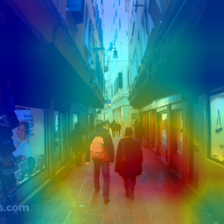

--------------------------------------------------
True Label: CITY
Predicted Label: CITY


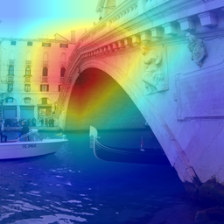

--------------------------------------------------
True Label: JUNGLE
Predicted Label: JUNGLE


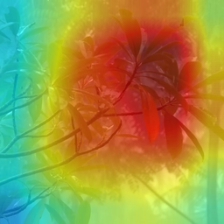

--------------------------------------------------
True Label: FOOTBALL-MATCH
Predicted Label: FOOTBALL-MATCH


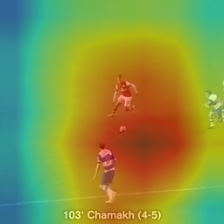

--------------------------------------------------
True Label: RESTAURANT
Predicted Label: RESTAURANT


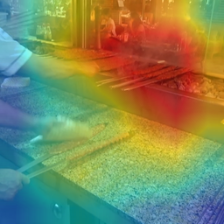

--------------------------------------------------
True Label: GROCERY-STORE
Predicted Label: GROCERY-STORE


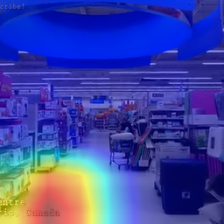

--------------------------------------------------
True Label: CITY
Predicted Label: CITY


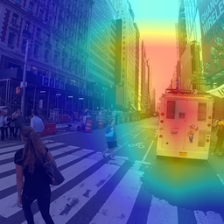

--------------------------------------------------
True Label: GROCERY-STORE
Predicted Label: GROCERY-STORE


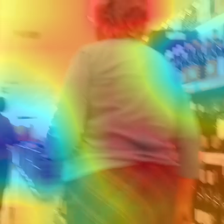

--------------------------------------------------
True Label: CLASSROOM
Predicted Label: CLASSROOM


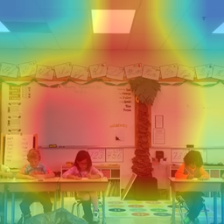

--------------------------------------------------
True Label: RIVER
Predicted Label: RIVER


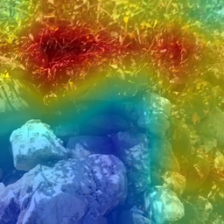

--------------------------------------------------


In [ ]:

path = "/content/drive/MyDrive/Multimodality/"

audio_file = pd.read_csv(path+'dataset.csv')
label_binarizer = LabelBinarizer()
label_binarizer.fit(audio_file['CLASS2'])
image_path_lst = audio_file['IMAGE']
class_labels = label_binarizer.classes_

grad_cam = GradCam(model=model, module='layer4', layer='1')

for i in range(10):

    random_image_path = random.choice(image_path_lst)


    label = audio_file[audio_file['IMAGE'] == random_image_path]['CLASS2'].values
    audio_data = audio_file[audio_file['IMAGE'] == random_image_path].iloc[0, 1:-2].values  # Adjust indexing based on dataset structure

    print("True Label:", label[0])


    img = cv2.imread(path + random_image_path, 1)
    img = np.float32(cv2.resize(img, (224, 224))) / 255
    input_img = preprocess_image(img)


    input_img = input_img.to(device)
    mask = grad_cam(input_img)


    audio_data = audio_data.astype(np.float32)
    audio_data = torch.tensor(audio_data, dtype=torch.float32).unsqueeze(0).to(device)


    with torch.no_grad():
        outputs = model(input_img, audio_data)
        _, predicted = torch.max(outputs, 1)


    predicted_label = class_labels[predicted.item()]

    print("Predicted Label:", predicted_label)


    show_cam_on_image(img, mask)
    print('-'*50)


# Counfusion Matrix

In [ ]:
audio_file = pd.read_csv(path+'dataset.csv')
label_binarizer = LabelBinarizer()
label_binarizer.fit(audio_file['CLASS2'])
image_path_lst = audio_file['IMAGE']
class_labels = label_binarizer.classes_

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



images, audio, labels = images.to(device), audio.to(device), labels.to(device)


outputs = model(images, audio)


NameError: name 'images' is not defined

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Evaluating: 100%|██████████| 108/108 [00:31<00:00,  3.39it/s]


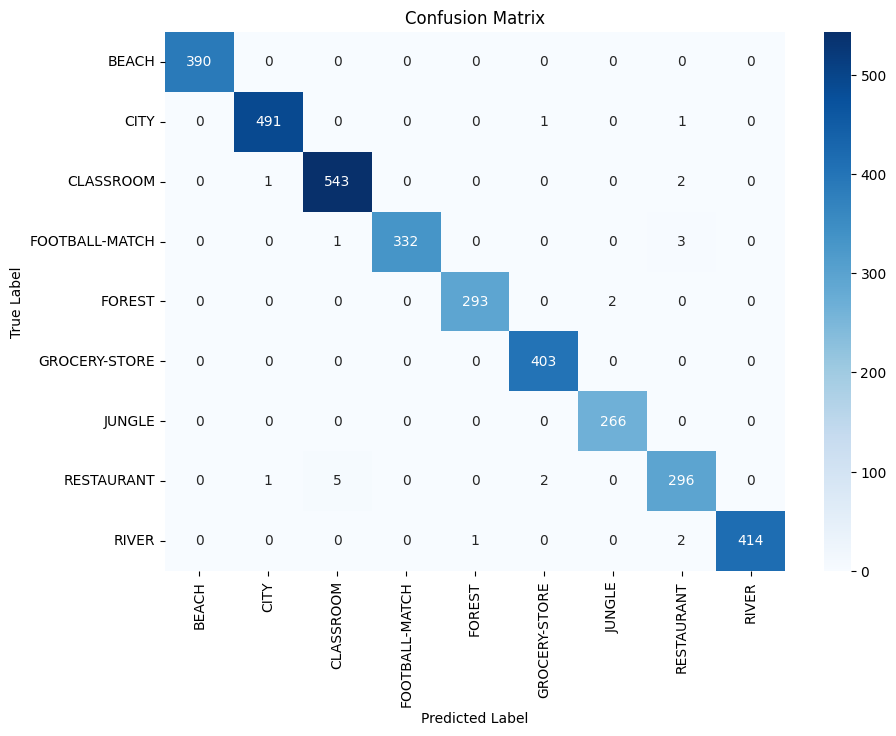

In [ ]:
from tqdm import tqdm


model.eval()


all_preds = []
all_labels = []


with torch.no_grad():
    for images, audio, labels in tqdm(val_loader, desc="Evaluating"):
        images, audio, labels = images.to(device), audio.to(device), labels.to(device)


        outputs = model(images, audio)
        _, predicted = torch.max(outputs, 1)


        true_labels = torch.argmax(labels, dim=1)


        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# CrossAttention Model

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        # Optional: Layer norm and FeedForward for post-processing
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
    def forward(self, video_embeddings, audio_embeddings):
        # Cross-attention: Q from video, K and V from audio
        attn_output, _ = self.attention(query=video_embeddings, key=audio_embeddings, value=audio_embeddings)
        attn_output = self.norm(attn_output + video_embeddings)  # Add residual connection
        output = self.fc(attn_output)  # Feedforward layer
        return output


In [ ]:
class ImageEmbeddingModel(nn.Module):
    def __init__(self, embed_dim):
        super(ImageEmbeddingModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_dim)

    def forward(self, x):
        return self.resnet(x)

class AudioEmbeddingModel(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super(AudioEmbeddingModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embed_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [ ]:
# 모델 초기화
image_embed_dim = 256
audio_embed_dim = 128

image_model = ImageEmbeddingModel(embed_dim=image_embed_dim).to(device)
audio_model = AudioEmbeddingModel(input_dim=len(dataset.audio_data.columns) - 3, embed_dim=audio_embed_dim).to(device)


image_model.eval()
audio_model.eval()


data_loader = DataLoader(dataset, batch_size=1, shuffle=False)


image_embeddings = []
audio_embeddings = []


with torch.no_grad():

    for images, audio, labels in tqdm(data_loader, desc='Extracting embeddings', unit='batch'):

        images, audio = images.to(device), audio.to(device)

        image_emb = image_model(images).cpu().numpy()
        image_embeddings.append(image_emb)


        audio_emb = audio_model(audio).cpu().numpy()
        audio_embeddings.append(audio_emb)


image_embeddings = np.vstack(image_embeddings)
audio_embeddings = np.vstack(audio_embeddings)


print("Image embeddings shape:", image_embeddings.shape)
print("Audio embeddings shape:", audio_embeddings.shape)


Extracting embeddings: 100%|██████████| 17252/17252 [1:50:25<00:00,  2.60batch/s]

Image embeddings shape: (17252, 256)
Audio embeddings shape: (17252, 128)


In [ ]:

image_embedding_path = 'image_embeddings.npy'
audio_embedding_path = 'audio_embeddings.npy'


np.save(image_embedding_path, image_embeddings)
np.save(audio_embedding_path, audio_embeddings)

print(f"Image embeddings saved to {image_embedding_path}")
print(f"Audio embeddings saved to {audio_embedding_path}")


Image embeddings saved to image_embeddings.npy
Audio embeddings saved to audio_embeddings.npy


In [ ]:

image_embeddings = np.load(image_embedding_path)
audio_embeddings = np.load(audio_embedding_path)

print("Image embeddings shape:", image_embeddings.shape)
print("Audio embeddings shape:", audio_embeddings.shape)


Image embeddings shape: (17252, 256)
Audio embeddings shape: (17252, 128)


In [ ]:

image_embeddings = torch.tensor(image_embeddings, dtype=torch.float32).to(device)
audio_embeddings = torch.tensor(audio_embeddings, dtype=torch.float32).to(device)



fused_output = cross_attention(image_embeddings, audio_embeddings)
print(fused_output.shape)  # Expected shape: (batch_size, seq_length, embed_dim)


AssertionError: was expecting embedding dimension of 128, but got 256

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        # Layer norm and FeedForward for post-processing
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        # Optional: Linear layer to match dimensions if necessary
        self.image_proj = nn.Linear(256, embed_dim)  # Reduce image embeddings to match audio embed_dim (128)

    def forward(self, video_embeddings, audio_embeddings):
        # Project video embeddings to the same dimension as audio
        video_embeddings_proj = self.image_proj(video_embeddings)

        # Cross-attention: Q from video, K and V from audio
        attn_output, _ = self.attention(query=video_embeddings_proj, key=audio_embeddings, value=audio_embeddings)
        attn_output = self.norm(attn_output + video_embeddings_proj)  # Add residual connection
        output = self.fc(attn_output)  # Feedforward layer
        return output

# Sample usage
if __name__ == "__main__":
    batch_size = 16
    seq_length = 50  # Sequence length of video/audio embeddings
    embed_dim = 128  # Embedding dimension for both audio and video
    num_heads = 4    # Number of attention heads

    # Initialize Cross Attention model
    cross_attention = CrossAttention(embed_dim=embed_dim, num_heads=num_heads)

    # Make sure image_embeddings and audio_embeddings are PyTorch tensors
    image_embeddings = torch.tensor(image_embeddings, dtype=torch.float32).to(device)
    audio_embeddings = torch.tensor(audio_embeddings, dtype=torch.float32).to(device)

    # Apply Cross Attention model
    fused_output = cross_attention(image_embeddings, audio_embeddings)
    print(fused_output.shape)  # Expected shape: (batch_size, seq_length, embed_dim)


<ipython-input-18-4ea79668b042>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_embeddings = torch.tensor(image_embeddings, dtype=torch.float32).to(device)
<ipython-input-18-4ea79668b042>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio_embeddings = torch.tensor(audio_embeddings, dtype=torch.float32).to(device)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
# Cross Attention
if __name__ == "__main__":
    batch_size = 16
    seq_length = 50  # Sequence length of video/audio embeddings
    embed_dim = 128  # Embedding dimension for both audio and video
    num_heads = 4    # Number of attention heads

    # Initialize Cross Attention model
    cross_attention = CrossAttention(embed_dim=embed_dim, num_heads=num_heads).to(device)

    # Make sure image_embeddings and audio_embeddings are PyTorch tensors and move to the same device
    image_embeddings = torch.tensor(image_embeddings, dtype=torch.float32).to(device)
    audio_embeddings = torch.tensor(audio_embeddings, dtype=torch.float32).to(device)

    # Apply Cross Attention model
    fused_output = cross_attention(image_embeddings, audio_embeddings)
    print(fused_output.shape)  # Expected shape: (batch_size, seq_length, embed_dim)


<ipython-input-19-449e06523e23>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_embeddings = torch.tensor(image_embeddings, dtype=torch.float32).to(device)
<ipython-input-19-449e06523e23>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio_embeddings = torch.tensor(audio_embeddings, dtype=torch.float32).to(device)


torch.Size([17252, 128])


In [ ]:

cross_attention = CrossAttention(embed_dim=embed_dim, num_heads=num_heads).to(device)


criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(cross_attention.parameters(), lr=1e-4)


In [ ]:

labels = torch.argmax(labels, dim=1)


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
def validate_model(model, image_model, audio_model, val_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, audio, labels in val_loader:
            images, audio, labels = images.to(device), audio.to(device), labels.to(device)


            image_emb = image_model(images)
            audio_emb = audio_model(audio)

            # Cross Attention
            fused_output = model(image_emb, audio_emb)

            labels = torch.argmax(labels, dim=1)


            _, predicted = torch.max(fused_output, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    return val_accuracy

In [ ]:
# training
for epoch in range(num_epochs):
    cross_attention.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, audio, labels in train_loader_tqdm:
        images, audio, labels = images.to(device), audio.to(device), labels.to(device)


        optimizer.zero_grad()


        image_emb = image_model(images)
        audio_emb = audio_model(audio)
        # Cross Attention
        fused_output = cross_attention(image_emb, audio_emb)


        labels = torch.argmax(labels, dim=1)


        loss = criterion(fused_output, labels)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


    val_accuracy = validate_model(cross_attention, image_model, audio_model, val_loader, device)
    print(f"Validation Accuracy: {val_accuracy:.4f}")




Epoch 1/10: 100%|██████████| 432/432 [02:40<00:00,  2.69batch/s, loss=0.164]

Epoch [1/10], Loss: 1.5138


Validation Accuracy: 0.8780


Epoch 2/10: 100%|██████████| 432/432 [02:21<00:00,  3.06batch/s, loss=0.946]

Epoch [2/10], Loss: 0.3261


Validation Accuracy: 0.9174


Epoch 3/10: 100%|██████████| 432/432 [02:22<00:00,  3.02batch/s, loss=0.0627]

Epoch [3/10], Loss: 0.2211


Validation Accuracy: 0.9345


Epoch 4/10: 100%|██████████| 432/432 [02:33<00:00,  2.82batch/s, loss=0.241]

Epoch [4/10], Loss: 0.1753


Validation Accuracy: 0.9499


Epoch 5/10: 100%|██████████| 432/432 [02:21<00:00,  3.05batch/s, loss=0.224]

Epoch [5/10], Loss: 0.1470


Validation Accuracy: 0.9551


Epoch 6/10: 100%|██████████| 432/432 [02:24<00:00,  3.00batch/s, loss=0.0389]

Epoch [6/10], Loss: 0.1294


Validation Accuracy: 0.9536


Epoch 7/10: 100%|██████████| 432/432 [02:20<00:00,  3.08batch/s, loss=0.127]

Epoch [7/10], Loss: 0.1176


Validation Accuracy: 0.9536


Epoch 8/10: 100%|██████████| 432/432 [02:24<00:00,  2.99batch/s, loss=0.0216]

Epoch [8/10], Loss: 0.1097


Validation Accuracy: 0.9617


Epoch 9/10: 100%|██████████| 432/432 [02:20<00:00,  3.09batch/s, loss=0.0753]

Epoch [9/10], Loss: 0.1006


Validation Accuracy: 0.9574


Epoch 10/10: 100%|██████████| 432/432 [02:24<00:00,  2.99batch/s, loss=0.0066]

Epoch [10/10], Loss: 0.0968


Validation Accuracy: 0.9629


In [ ]:

model_save_path = 'crossAttention_multimodal_model.pth'


torch.save(model.state_dict(), model_save_path)
print(f" {model_save_path} is saved.")


모델이 crossAttention_multimodal_model.pth에 저장되었습니다.


In [ ]:

model = MultimodalModel(num_audio_features, num_classes)


model.load_state_dict(torch.load(model_save_path))

model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-31-a560be702fc8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

MultimodalModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr